In [73]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 


matplotlib.rcParams['figure.figsize'] = (25, 5)

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 5
cfg.obs_dim = 50
cfg.p_factor = 2
cfg.covar_factor = np.eye(cfg.factor_dim)/100
cfg.p_eps = 5
cfg.covar_eps = np.eye(cfg.obs_dim)/1000
cfg.T_train = 1024
cfg.T_test = 1024
cfg.T = cfg.T_train + cfg.T_test

## Nonlinear decoder DGP
Obtain the simulated $y$

Obtained stable system after 153 iterations.
Obtained stable system after 195 iterations.


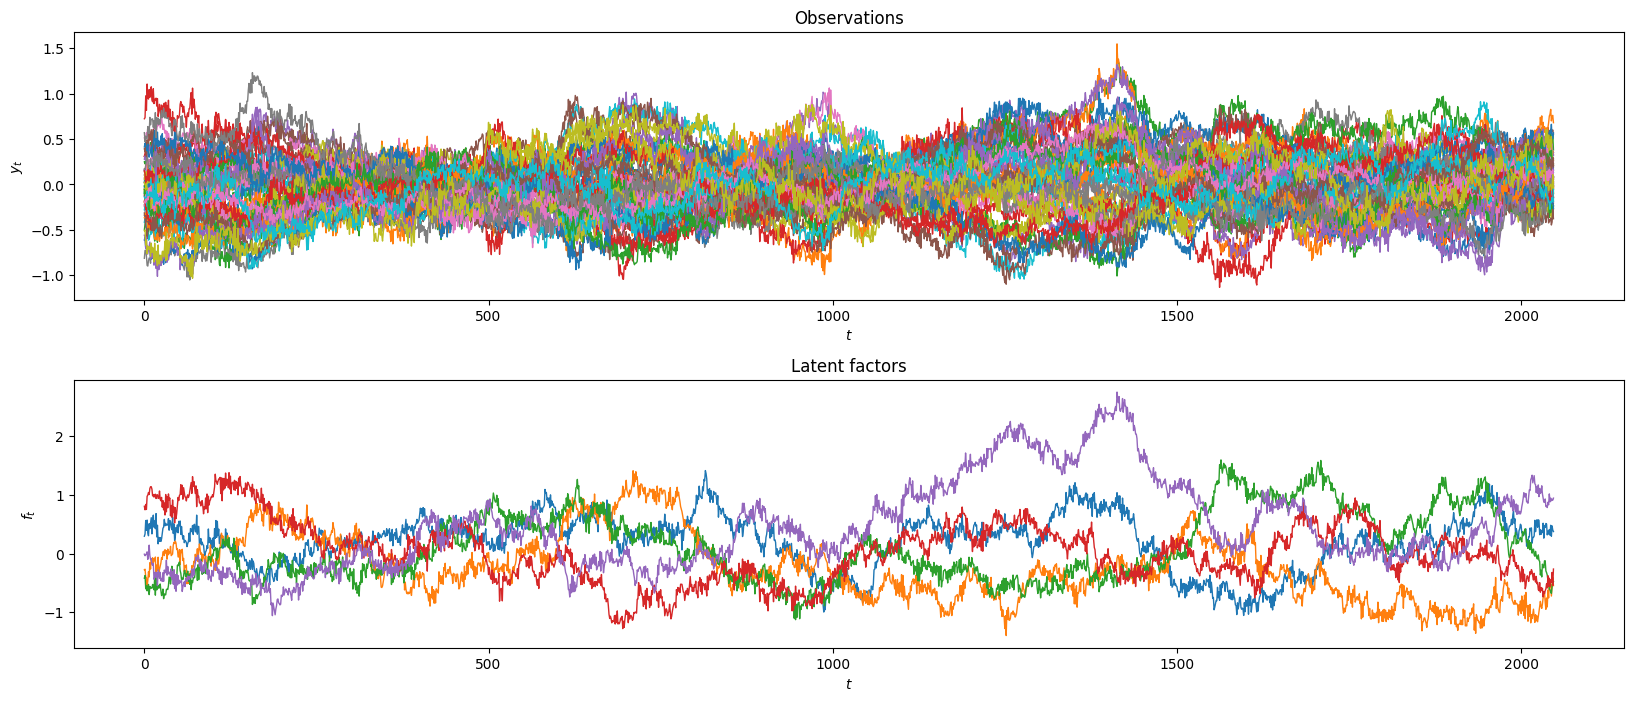

In [114]:
dec = Decoder(hidden_dim=[cfg.factor_dim, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False)
f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, centered=True)

f_train = f[0:cfg.T_train]
f_test = f[cfg.T_train:]

y_train = y[0:cfg.T_train]
y_test = y[cfg.T_train:]

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

In [76]:
#j = jacobian(dec, torch.Tensor(f[0]).float()).detach().numpy()
#cov = j @ cfg.covar_factor @ j.T
#cov.shape

In [77]:
#forecasting


## Estimate nonlinear model
TODO: this should all be hyperparameter tuned etc.

In [115]:
def cca_callback_gen(mod, f, y):
    def cca_callback(train_hist):
        if 'cca_r2' not in train_hist.keys():
            train_hist['cca_r2'] = []
        f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()
        cc = np.mean(CanCorr(f_hat, f).cancorr)
        train_hist['cca_r2'].append(cc)
    return cca_callback
        

In [116]:
dec = Decoder(hidden_dim=[cfg.factor_dim, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False)
enc = Encoder(hidden_dim=[cfg.obs_dim, cfg.factor_dim], activation=nn.Tanh(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
cback = cca_callback_gen(mod, f, y)
train_hist = trainMCMC(X=y,model=mod, errorProcess = errorProcess, n_epoch=20, lr = 0.0001, epoch_callback=cback, batch_size=256)
print(f"Training loss: {train_hist['loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")
nonlinear_train_hist = train_hist #save for comparison later on

Number of trainable paramaters 555
2048 614
(50,) (50, 50)
1 0.9354258115401405115401405
2 0.027372897661109737661109737
3 0.013003886381452754381452754
4 0.012118280258072593258072593
5 0.012130504157049717157049717
Training loss: 0.012130504157049717, Validation Loss: 0.03806865331792676


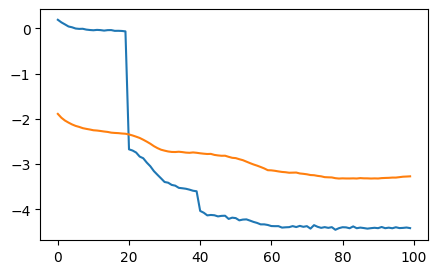

In [117]:
plot_train_hist(train_hist, log=True)

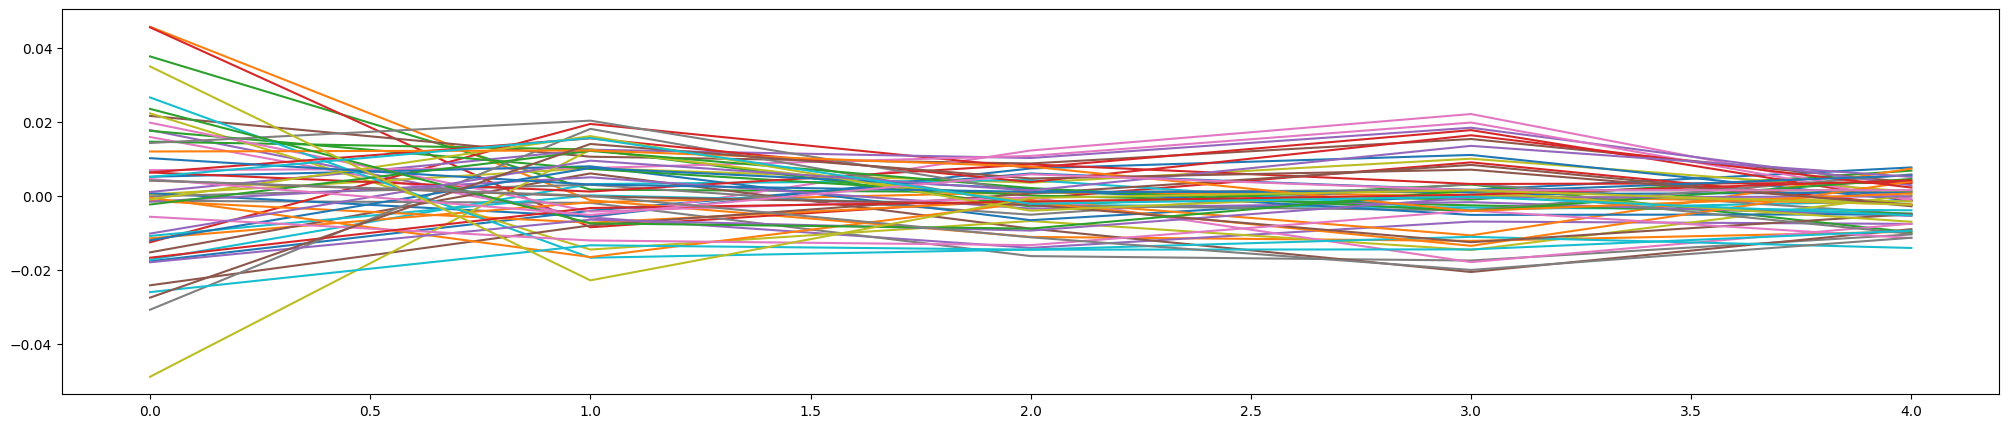

In [105]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

In [118]:
#plt.plot(np.stack(errorProcess.fit_hist['coeff'])[:,:,4]);

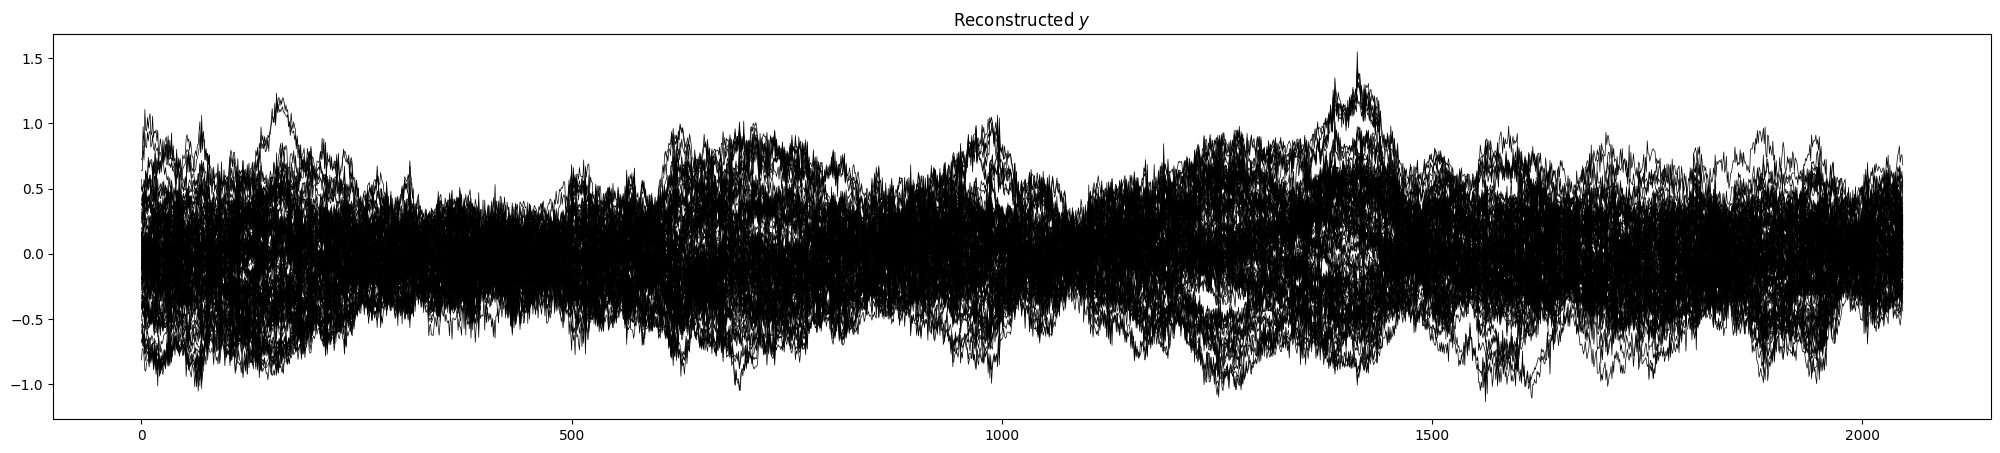

In [119]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


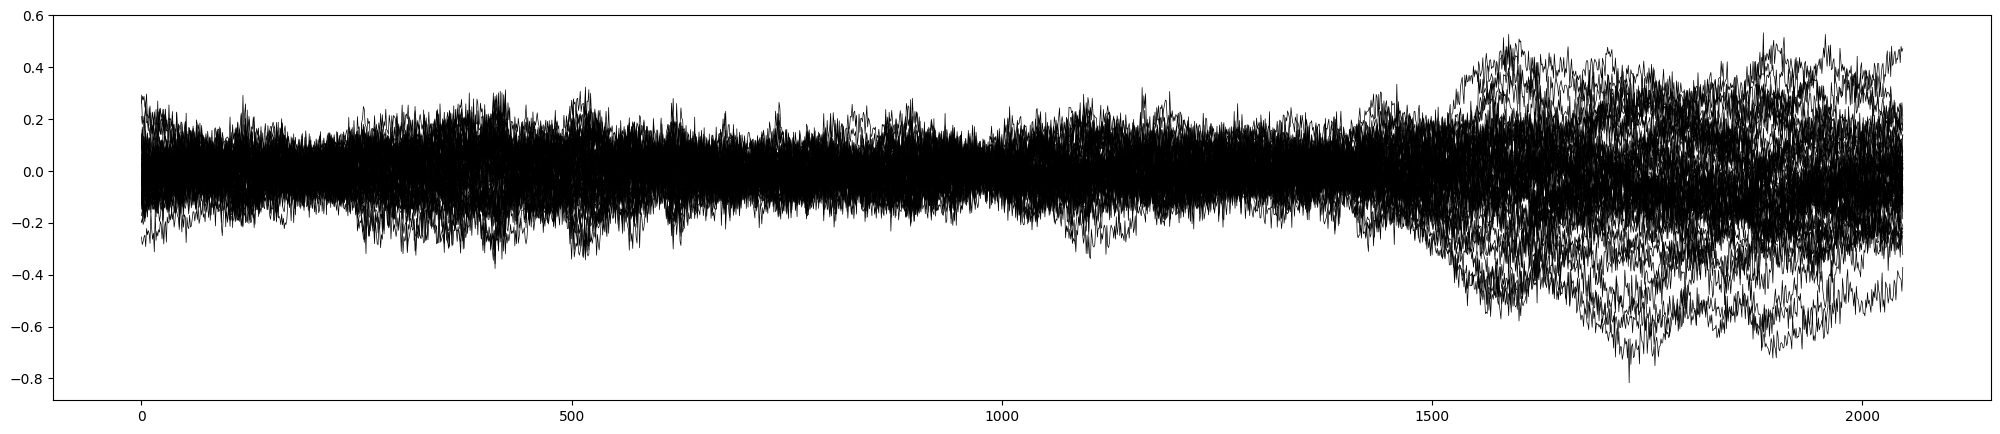

In [120]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

Text(0, 0.5, 'Mean cann. corr.')

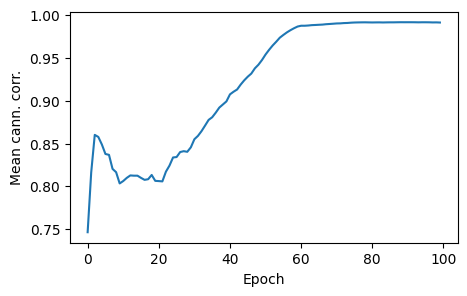

In [121]:
plt.figure(figsize=(5,3))
plt.plot(train_hist['cca_r2'])
plt.xlabel('Epoch')
plt.ylabel('Mean cann. corr.')

In [109]:
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_train_hat, f_train)
X_c, Y_c = cca.transform(f_train_hat, f_train)

# calculate and plot the correlations of all components
print("cc on train data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_test_hat, f_test)
X_c, Y_c = cca.transform(f_test_hat, f_test)

# calculate and plot the correlations of all components
print("cc on test data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

cc on train data: 0.8589941431385588
cc on test data: 0.9448396691102404
cc on train data:  0.8589940607028561
cc on test data:  0.9448395847455192


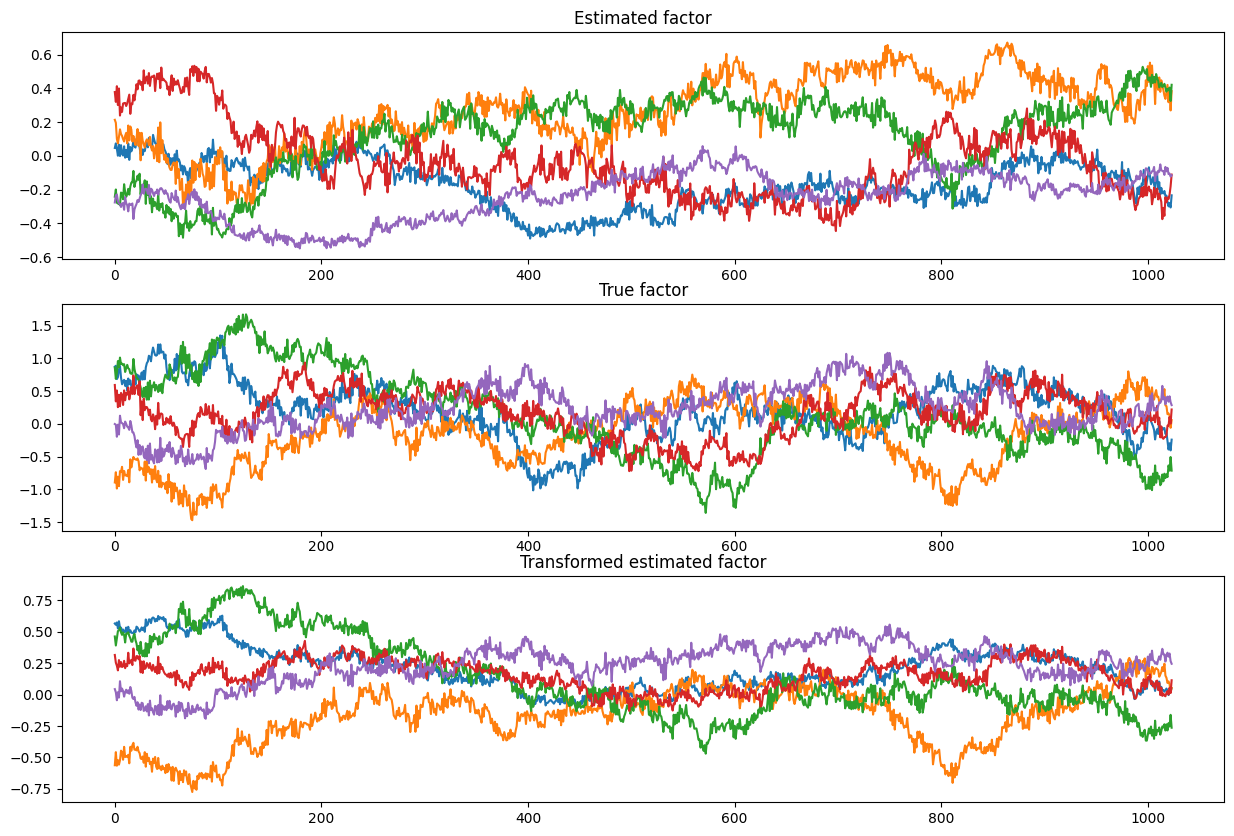

In [87]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

1-step ahead  FMSE on the test set: 0.015155469998717308


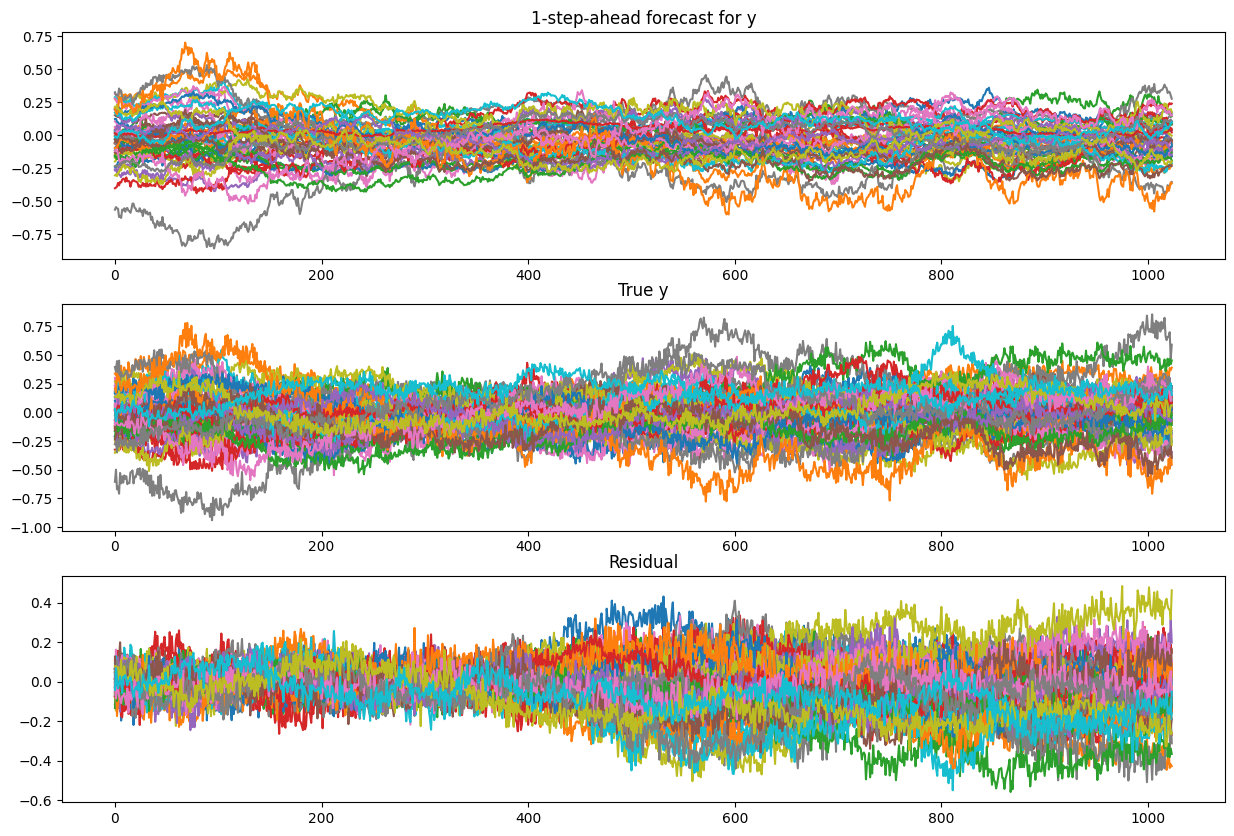

In [88]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()[-cfg.T_test:]

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")

## Estimate linear model on nonlinear DGP

In [122]:
dec = Decoder(hidden_dim=[cfg.factor_dim, cfg.obs_dim], activation=nn.Identity())
enc = Encoder(hidden_dim=[cfg.obs_dim, cfg.factor_dim], activation=nn.Identity())
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
cback = cca_callback_gen(mod, f, y)
train_hist = trainMCMC(X=y,model=mod, errorProcess = errorProcess, n_epoch=20, lr = 0.0001, epoch_callback=cback, batch_size=256)
linear_train_hist = train_hist
print(f"Training loss: {train_hist['loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

Number of trainable paramaters 555
2048 614
(50,) (50, 50)
1 0.9202174375877464375877462
2 0.025200042513895207513895207
3 0.013621760283993910283993912
4 0.012076860429902365429902365
5 0.012214343595648343595648979
Training loss: 0.012214343595648, Validation Loss: 0.03551762422443601


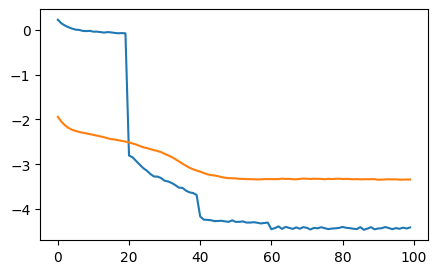

In [132]:
plot_train_hist(train_hist, log=True)

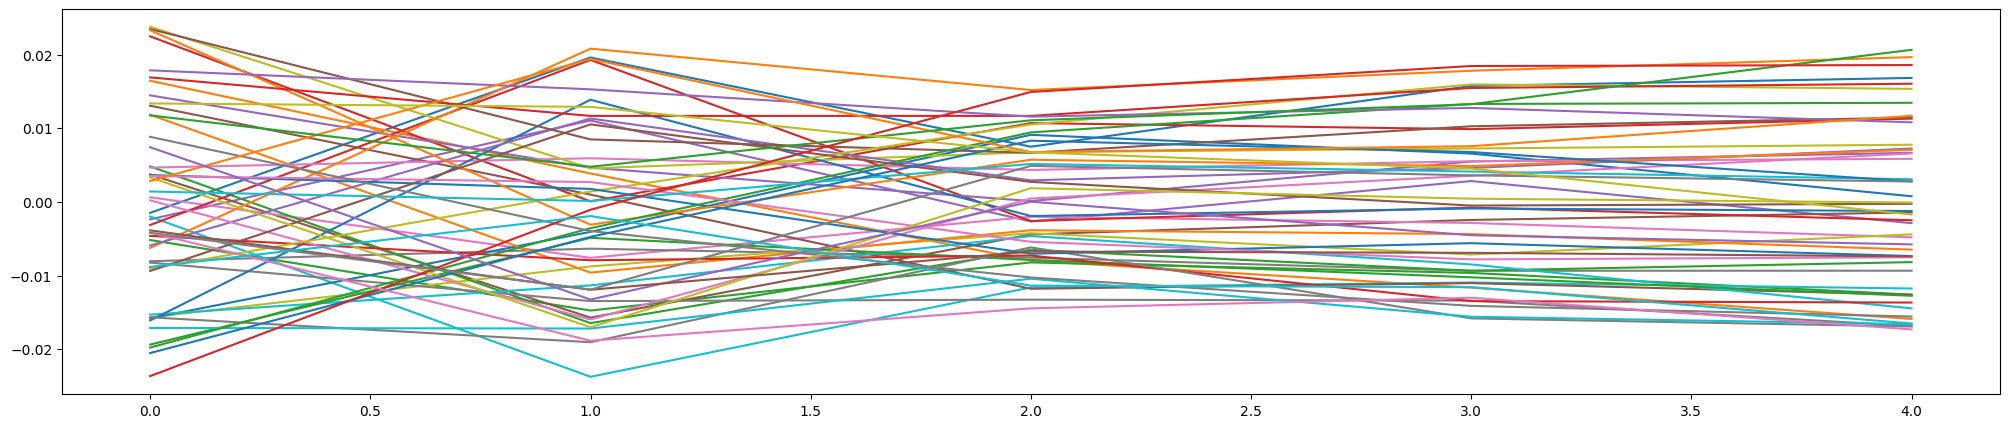

In [133]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

In [125]:
#plt.plot(np.stack(errorProcess.fit_hist['coeff'])[:,:,4]);

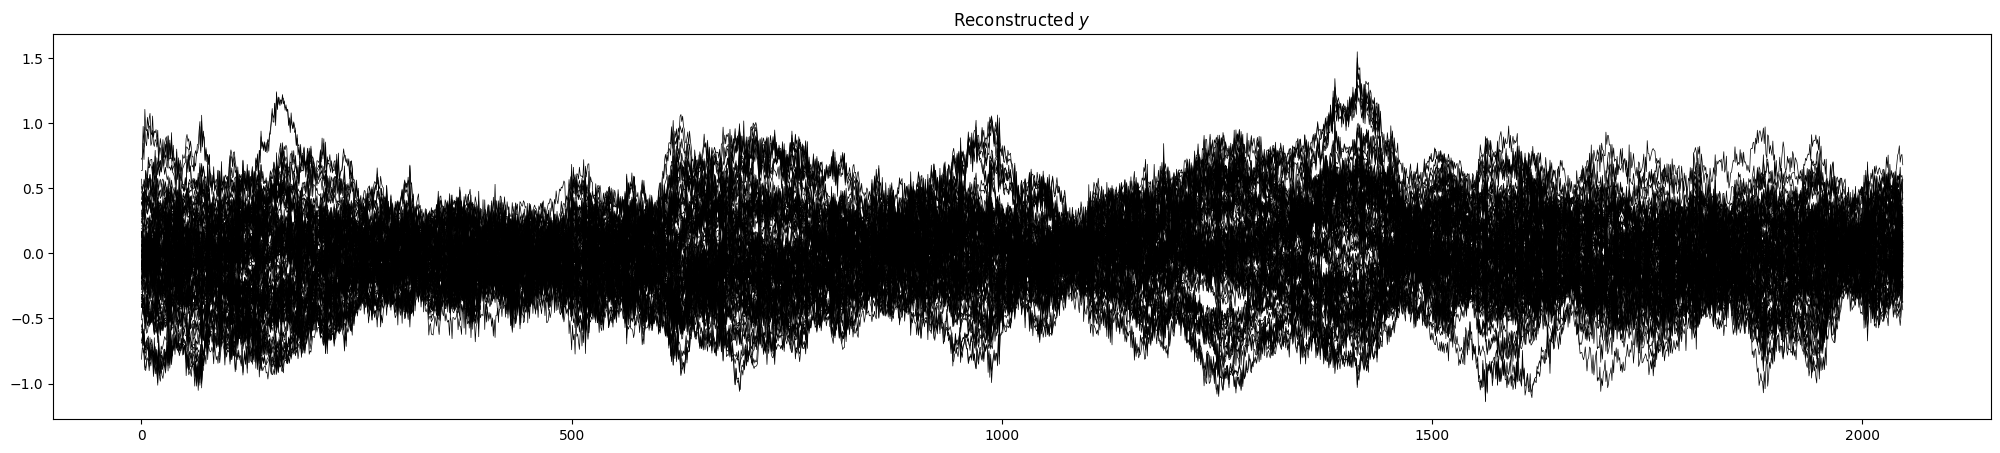

In [126]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


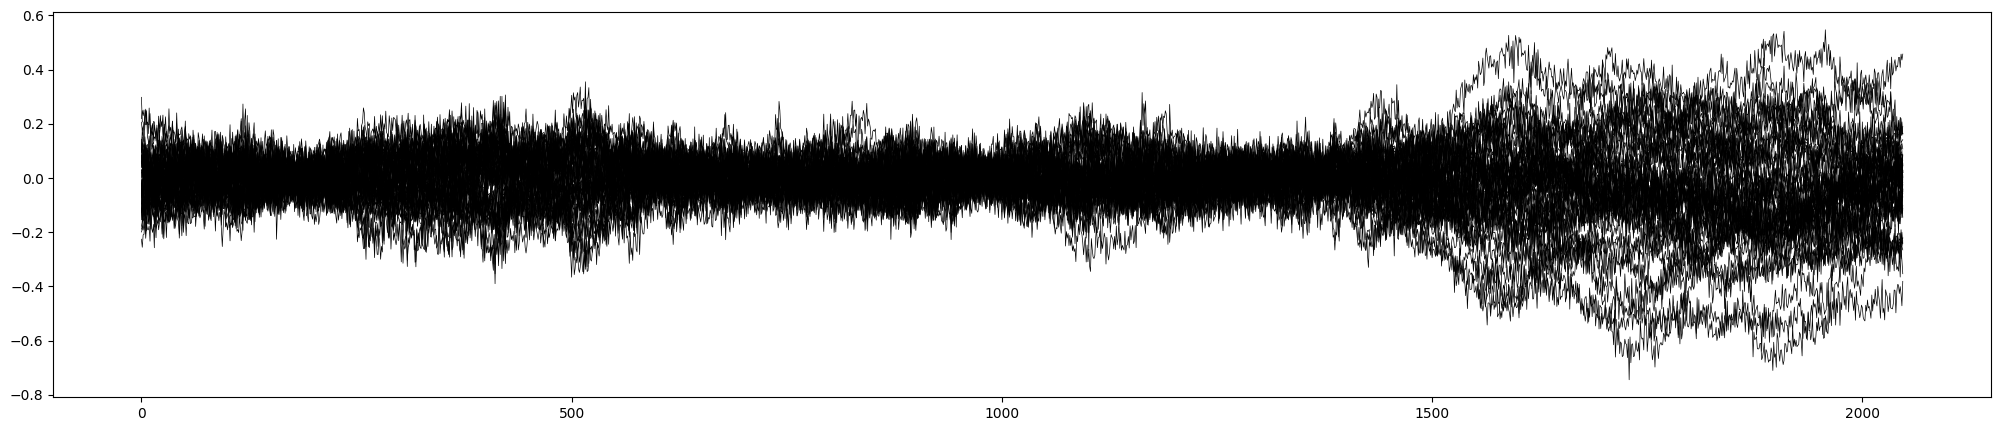

In [127]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

Text(0, 0.5, 'Mean cann. corr.')

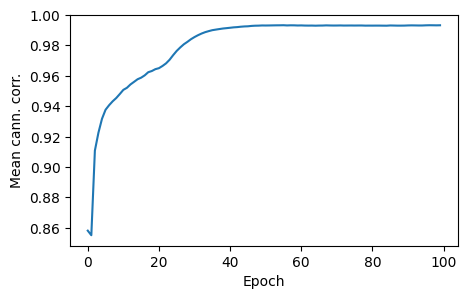

In [128]:
plt.figure(figsize=(5,3))
plt.plot(train_hist['cca_r2'])
plt.xlabel('Epoch')
plt.ylabel('Mean cann. corr.')

In [129]:
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

cn_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_train_hat, f_train)
X_c, Y_c = cca.transform(f_train_hat, f_train)

# calculate and plot the correlations of all components
print("cc on train data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

cn_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_test_hat, f_test)
X_c, Y_c = cca.transform(f_test_hat, f_test)

# calculate and plot the correlations of all components
print("cc on test data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

cc on train data: 0.9934321782599703
cc on test data: 0.9907159244619367
cc on train data:  0.9934320432962822
cc on test data:  0.9907156998520165


/Users/julianvanmeggelen/Library/Python/3.9/lib/python/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/julianvanmeggelen/Library/Python/3.9/lib/python/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


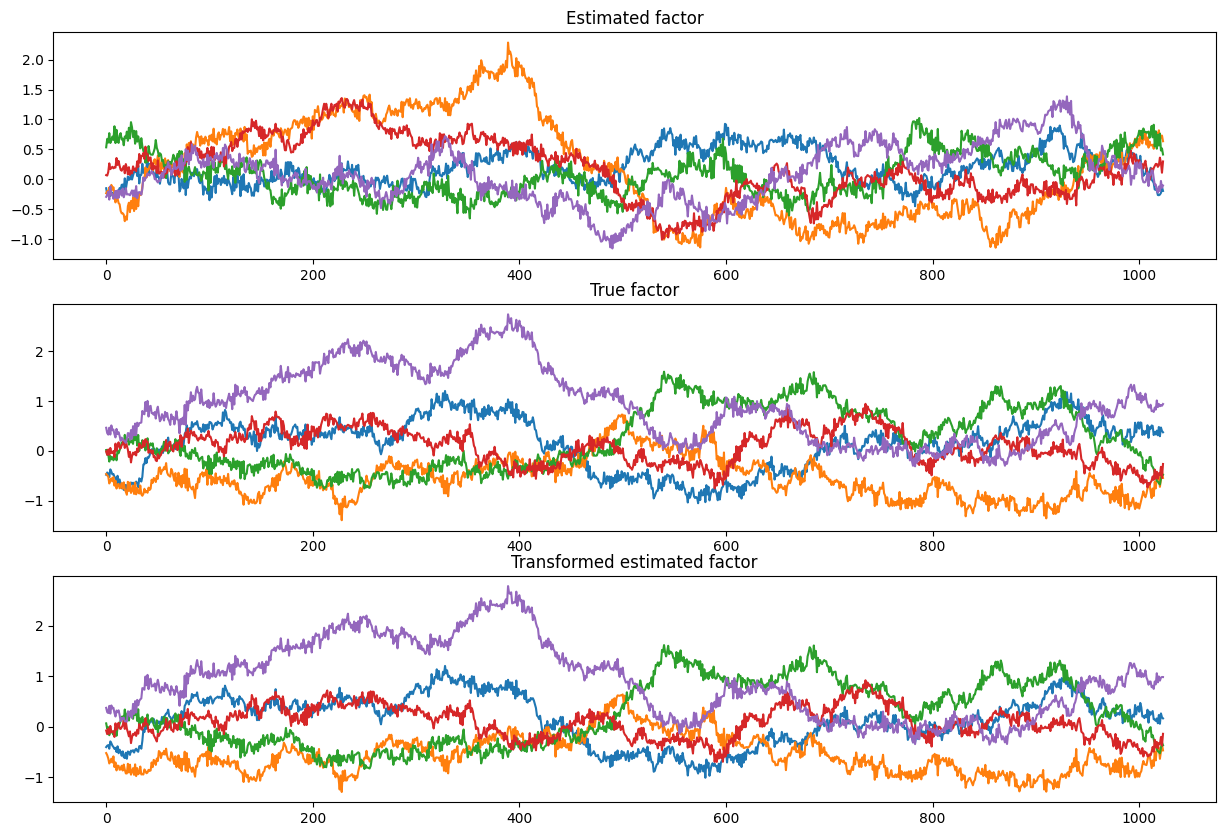

In [130]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

1-step ahead  FMSE on the test set: 0.026551848277449608


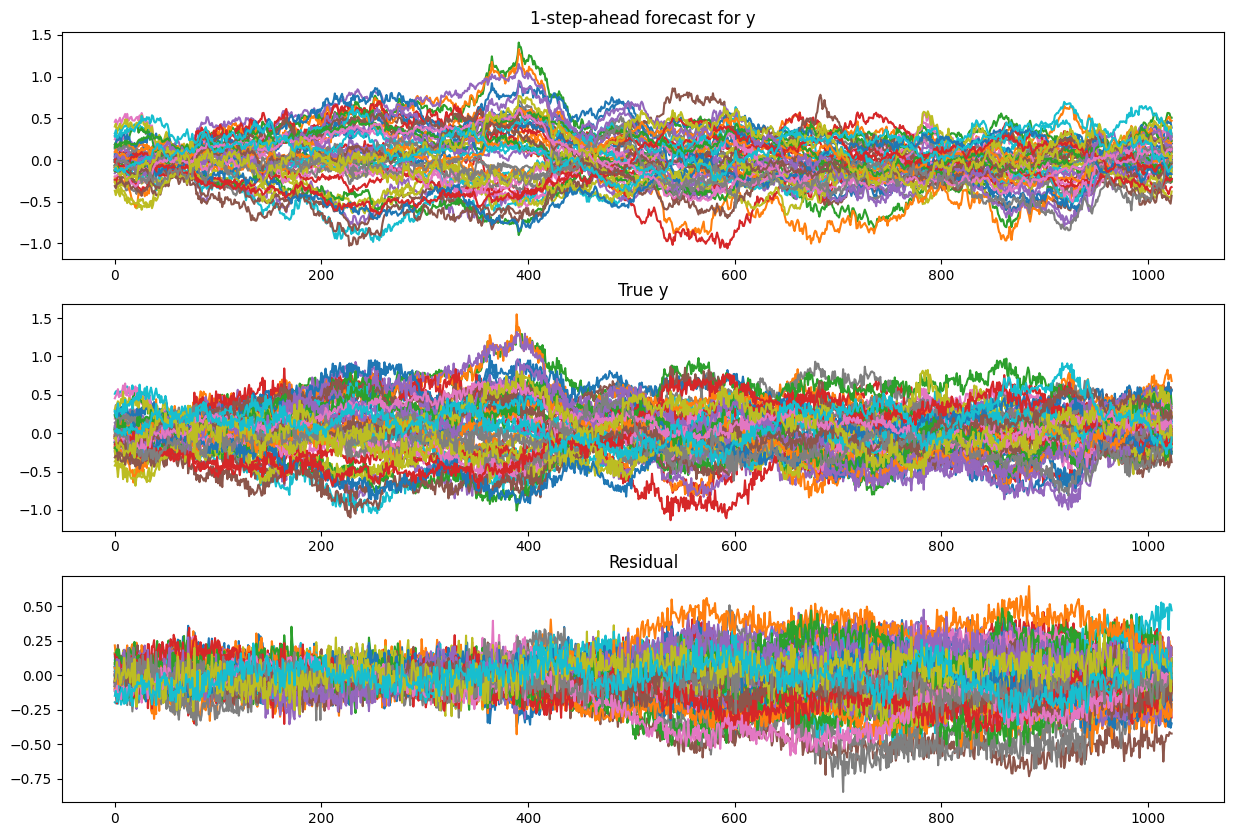

In [131]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()[-cfg.T_test:]

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")